# EDA of European Soccer Database

* Original Kaggle dataset: https://www.kaggle.com/hugomathien/soccer
* Reference for betting odds columns: http://www.football-data.co.uk/notes.txt

### Other resources:

* https://www.researchgate.net/publication/46527004_Bayesian_hierarchical_model_for_the_prediction_of_football_results
* https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import pystan as stan
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.stats import bernoulli
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy
import itertools
import arviz as az
import sqlite3
from tqdm import tqdm

pd.options.display.max_columns=None
pd.options.display.max_rows=100

SEED = 42
start_date = '2010-08-01'

In [15]:
conn = sqlite3.connect('database.sqlite')
cursor = conn.cursor()

sql_match = """SELECT * FROM Match"""
sql_league = """SELECT * FROM League"""
sql_team = """SELECT * FROM Team"""
sql_team_attributes = """SELECT * FROM Team_Attributes"""
sql_player = """SELECT * FROM Player"""
sql_player_attributes = """SELECT * FROM Player_Attributes"""

In [16]:
# loading the data
df_match = pd.read_sql(sql_match, conn)
df_match.shape

(25979, 115)

In [17]:
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [18]:
df_league = pd.read_sql(sql_league, conn)
print(df_league.shape)
df_league

(11, 3)


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [6]:
df_team = pd.read_sql(sql_team, conn)
print(df_team.shape)
df_team.head()

(299, 5)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [7]:
df_team_attributes = pd.read_sql(sql_team_attributes, conn)
print(df_team_attributes.shape)
df_team_attributes.head()

(1458, 25)


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [8]:
df_player = pd.read_sql(sql_player, conn)
print(df_player.shape)
df_player.head()

(11060, 7)


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [9]:
df_player_attributes = pd.read_sql(sql_player_attributes, conn)
print(df_player_attributes.shape)
df_player_attributes.head()

(183978, 42)


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


# Take a subset of matches from La Liga

In [10]:
match_id_spain = 21518
df_match_spain = df_match[df_match['league_id'] == match_id_spain]
df_match_spain = df_match_spain[pd.to_datetime(df_match_spain['date']) >= pd.to_datetime(start_date)]
print(df_match_spain.shape)

(2280, 115)


In [11]:
df_match_spain.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
22277,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,875448,9906,9869,4,0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,4.0,6.0,3.0,5.0,7.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,6.0,6.0,8.0,8.0,8.0,11.0,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>62</comment><elaps...,1.53,4.00,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,NaN,NaN,NaN,1.50,3.80,6.00,1.57,3.75,6.00,1.53,3.80,6.00,1.50,4.00,6.0,1.57,3.75,5.50
22278,22279,21518,21518,2010/2011,1,2010-08-28 00:00:00,875451,10278,8315,0,1,1.0,2.0,6.0,8.0,4.0,4.0,6.0,3.0,5.0,7.0,5.0,1.0,2.0,4.0,6.0,8.0,4.0,6.0,2.0,8.0,4.0,6.0,1.0,3.0,3.0,3.0,3.0,6.0,6.0,8.0,8.0,8.0,11.0,1.0,3.0,3.0,3.0,3.0,5.0,5.0,7.0,7.0,10.0,10.0,37511.0,37470.0,33715.0,33609.0,24630.0,18376.0,24385.0,NaN,96852.0,74772.0,37497.0,33764.0,33025.0,182224.0,37604.0,191136.0,37410.0,33024.0,96619.0,37408.0,33030.0,150832.0,<goal><value><comment>n</comment><stats><goals...,<shoton />,<shotoff />,<foulcommit />,<card><value><comment>y</comment><stats><ycard...,<cross />,<corner />,<possession />,2.50,3.25,2.8,2.55,3.20,2.65,2.6,3.1,2.50,2.5,3.2,2.50,NaN,NaN,NaN,2.50,3.20,2.60,2.60,3.20,2.75,2.50,3.12,2.75,2.60,3.25,2.6,2.50,3.25,2.60
22279,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,875458,8696,8634,0,3,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,3.0,5.0,7.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,10.0,10.0,10.0,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>38</comment><event...,15.00,6.00,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,NaN,NaN,NaN,11.00,5.50,1.22,13.00,6.50,1.20,15.00,6.50,1.20,13.00,6.00,1.2,11.00,5.50,1.22
22280

# Subset teams, players, team_attributes, and player_attributes

In [12]:
list_match_cols = [
    'id',
    'country_id',
    'league_id',
    'season',
    'stage',
    'date',
    'home_team_goal',
    'away_team_goal',
    'match_api_id',
    'home_team_api_id',
    'away_team_api_id',
    'home_player_1',
    'home_player_2',
    'home_player_3',
    'home_player_4',
    'home_player_5',
    'home_player_6',
    'home_player_7',
    'home_player_8',
    'home_player_9',
    'home_player_10',
    'home_player_11',
    'away_player_1',
    'away_player_2',
    'away_player_3',
    'away_player_4',
    'away_player_5',
    'away_player_6',
    'away_player_7',
    'away_player_8',
    'away_player_9',
    'away_player_10',
    'away_player_11',
    'B365H',
    'B365D',
    'B365A',
    'BWH',
    'BWD',
    'BWA',
    'IWH',
    'IWD',
    'IWA',
    'LBH',
    'LBD',
    'LBA',
    'PSH',
    'PSD',
    'PSA',
    'WHH',
    'WHD',
    'WHA',
    'SJH',
    'SJD',
    'SJA',
    'VCH',
    'VCD',
    'VCA',
    'GBH',
    'GBD',
    'GBA',
    'BSH',
    'BSD',
    'BSA',
]

In [13]:
df_match_spain = df_match_spain[list_match_cols]
df_match_spain.head()

,id,country_id,league_id,season,stage,date,home_team_goal,away_team_goal,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
22277,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,4,0,875448,9906,9869,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,1.53,4.00,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,NaN,NaN,NaN,1.50,3.80,6.00,1.57,3.75,6.00,1.53,3.80,6.00,1.50,4.00,6.0,1.57,3.75,5.50
22278,22279,21518,21518,2010/2011,1,2010-08-28 00:00:00,0,1,875451,10278,8315,37511.0,37470.0,33715.0,33609.0,24630.0,18376.0,24385.0,NaN,96852.0,74772.0,37497.0,33764.0,33025.0,182224.0,37604.0,191136.0,37410.0,33024.0,96619.0,37408.0,33030.0,150832.0,2.50,3.25,2.8,2.55,3.20,2.65,2.6,3.1,2.50,2.5,3.2,2.50,NaN,NaN,NaN,2.50,3.20,2.60,2.60,3.20,2.75,2.50,3.12,2.75,2.60,3.25,2.6,2.50,3.25,2.60
22279,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,3,875458,8696,8634,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,15.00,6.00,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,NaN,NaN,NaN,11.00,5.50,1.22,13.00,6.50,1.20,15.00,6.50,1.20,13.00,6.00,1.2,11.00,5.50,1.22
22280,22281,21518,21518,2010/2011,1,2010-08-28 00:00:00,1,3,875459,9864,10267,33826.0,33843.0,188517.0,41707.0,163236.0,11758.0,24612.0,128870.0,23779.0,56819.0,51545.0,24494.0,34007.0,30276.0,30914.0,26403.0,108568.0,30666.0,37824.0,41468.0,32762.0,33028.0,2.88,3.30,2.4,2.85,3.30,2.35,2.7,3.2,2.40,2.8,3.2,2.20,NaN,NaN,NaN,2.90,3.25,2.25,2.80,3.25,2.50,2.88,3.20,2.40,2.85,3.25,2.4,2.90,3.25,2.30
22281,22282,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,0,875462,9783,8394,96651.0,33756.0,37451.0,70891.0,18853.0,37449.0,37793.0,114680.0,45744.0,31045.0,166111.0,30664.0,37754.0,33582.0,27668.0,150968.0,33635.0,30534.0,38403.0,164676.0,45457.0,8780.0,2.10,3.30,3.5,2.05,3.25,3.50,2.0,3.2,3.40,2.0,3.2,3.20,NaN,NaN,NaN,1.91,3.30,3.75,2.10,3.20,3.60,2.05,3.25,3.50,2.00,3.30,3.6,2.05,3.25,3.40


In [14]:
list_na_cols = []
for col in df_match_spain:
    if df_match_spain[col].isna().sum() > 0:
        if df_match_spain[col].isna().sum() > 20:
            print(col, df_match_spain[col].isna().sum())
            list_na_cols.append(col)

PSH 763
PSD 763
PSA 763
SJH 731
SJD 731
SJA 731
GBH 1145
GBD 1145
GBA 1145
BSH 1140
BSD 1140
BSA 1140


In [15]:
list_match_cols_update = [c for c in list_match_cols if c not in list_na_cols]
print(len(list_match_cols_update))
print(list_match_cols_update)

51
['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'home_team_goal', 'away_team_goal', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA']


In [16]:
df_match_spain.to_parquet('df_match_spain_raw.parquet')

In [17]:
df_match_spain_sub = df_match_spain[list_match_cols_update].dropna()
print(df_match_spain_sub.shape)

(2173, 51)


In [18]:
df_match_spain_sub.head()

,id,country_id,league_id,season,stage,date,home_team_goal,away_team_goal,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
22277,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,4,0,875448,9906,9869,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,1.53,4.0,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,1.50,3.80,6.00,1.53,3.80,6.0
22279,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,3,875458,8696,8634,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,15.00,6.0,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,11.00,5.50,1.22,15.00,6.50,1.2
22280,22281,21518,21518,2010/2011,1,2010-08-28 00:00:00,1,3,875459,9864,10267,33826.0,33843.0,188517.0,41707.0,163236.0,11758.0,24612.0,128870.0,23779.0,56819.0,51545.0,24494.0,34007.0,30276.0,30914.0,26403.0,108568.0,30666.0,37824.0,41468.0,32762.0,33028.0,2.88,3.3,2.4,2.85,3.30,2.35,2.7,3.2,2.40,2.8,3.2,2.20,2.90,3.25,2.25,2.88,3.20,2.4
22281,22282,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,0,875462,9783,8394,96651.0,33756.0,37451.0,70891.0,18853.0,37449.0,37793.0,114680.0,45744.0,31045.0,166111.0,30664.0,37754.0,33582.0,27668.0,150968.0,33635.0,30534.0,38403.0,164676.0,45457.0,8780.0,2.10,3.3,3.5,2.05,3.25,3.50,2.0,3.2,3.40,2.0,3.2,3.20,1.91,3.30,3.75,2.05,3.25,3.5
22283,22284,21518,21518,2010/2011,1,2010-08-29 00:00:00,3,1,875464,8558,8305,113695.0,45440.0,183331.0,182921.0,33767.0,80492.0,121716.0,24852.0,37441.0,150330.0,40165.0,30992.0,41470.0,32675.0,75397.0,37622.0,34381.0,38431.0,75619.0,75307.0,37461.0,150770.0,2.10,3.3,3.5,2.15,3.25,3.25,2.0,3.2,3.40,2.1,3.2,3.00,2.10,3.25,3.25,2.10,3.20,3.5


In [19]:
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [20]:
df_team_spain = df_team[(df_team['team_api_id'].isin(df_match_spain_sub['home_team_api_id'].values)) | 
                        (df_team['team_api_id'].isin(df_match_spain_sub['away_team_api_id'].values))]
df_team_spain.shape

(29, 5)

In [21]:
df_team_spain

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
251,43035,10267,461.0,Valencia CF,VAL
252,43036,8661,453.0,RCD Mallorca,MAL
253,43037,8371,479.0,CA Osasuna,OSA
254,43038,10205,483.0,Villarreal CF,VIL
255,43039,9783,242.0,RC Deportivo de La Coruña,COR
256,43040,8633,243.0,Real Madrid CF,REA
258,43042,8634,241.0,FC Barcelona,BAR
259,43043,8696,456.0,Racing Santander,SAN
260,43044,8302,481.0,Sevilla FC,SEV
261,43045,9869,459.0,Real Sporting de Gijón,SPG


In [22]:
df_team_spain.to_parquet("df_team_spain.parquet")

In [21]:
list_all_players = []

for col in df_match_spain_sub.columns:
    if 'player' in col:
        list_all_players.extend(df_match_spain_sub[col].unique())

In [22]:
df_player_spain = df_player[df_player['player_api_id'].isin(list_all_players)]
print(df_player_spain.shape)
df_player_spain.head()

(1262, 7)


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
13,14,40719,Aaron Niguez,183853,1989-04-26 00:00:00,170.18,143
20,21,167027,Abdelaziz Barrada,192274,1989-06-19 00:00:00,177.80,161
23,24,42664,Abdelkader Ghezzal,178063,1984-12-05 00:00:00,182.88,172
35,36,67334,Abdoul Karim Yoda,188232,1988-10-25 00:00:00,182.88,161
37,38,39562,Abdoulay Konko,161999,1984-03-09 00:00:00,182.88,157


In [23]:
df_player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [24]:
df_player_spain_attr = pd.merge(
    df_player_spain,
    df_player_attributes,
    on='player_fifa_api_id',
    how='left',
    suffixes=('', '_attributes')
)
df_player_spain_attr.shape

(26431, 48)

In [25]:
df_player_spain_attr.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id_attributes,player_api_id_attributes,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,14,40719,Aaron Niguez,183853,1989-04-26 00:00:00,170.18,143,243,40719,2016-04-28 00:00:00,70.0,71.0,left,medium,medium,64.0,67.0,54.0,64.0,61.0,75.0,66.0,68.0,56.0,76.0,82.0,78.0,82.0,66.0,84.0,74.0,70.0,67.0,51.0,72.0,45.0,45.0,70.0,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0
1,14,40719,Aaron Niguez,183853,1989-04-26 00:00:00,170.18,143,244,40719,2016-04-14 00:00:00,70.0,72.0,left,medium,medium,64.0,67.0,54.0,64.0,61.0,75.0,66.0,68.0,56.0,76.0,82.0,78.0,82.0,66.0,84.0,74.0,70.0,67.0,51.0,72.0,45.0,45.0,70.0,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0
2,14,40719,Aaron Niguez,183853,1989-04-26 00:00:00,170.18,143,245,40719,2016-01-21 00:00:00,70.0,72.0,left,medium,medium,64.0,67.0,54.0,64.0,61.0,75.0,66.0,68.0,56.0,76.0,82.0,78.0,82.0,66.0,84.0,74.0,70.0,67.0,51.0,72.0,45.0,45.0,70.0,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0
3,14,40719,Aaron Niguez,183853,1989-04-26 00:00:00,170.18,143,246,40719,2015-12-17 00:00:00,71.0,73.0,left,medium,medium,64.0,67.0,54.0,64.0,61.0,76.0,66.0,68.0,60.0,77.0,82.0,78.0,82.0,66.0,84.0,74.0,70.0,73.0,51.0,72.0,45.0,45.0,70.0,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0
4,14,40719,Aaron Niguez,183853,1989-04-26 00:00:00,170.18,143,247,40719,2015-11-12 00:00:00,71.0,73.0,left,medium,medium,64.0,67.0,54.0,64.0,61.0,76.0,66.0,68.0,60.0,77.0,82.0,78.0,82.0,66.0,84.0,68.0,70.0,73.0,51.0,62.0,45.0,45.0,70.0,62.0,67.0,36.0,31.0,37.0,14.0,13.0,9.0,15.0,10.0


# Some preprocessing

In [26]:
df_player_spain_attr['year'] = pd.to_datetime(df_player_spain_attr['date']).dt.year
df_player_spain_attr = df_player_spain_attr.sort_values(['player_api_id', 'date'], ascending=False)
df_player_spain_attr.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id_attributes,player_api_id_attributes,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,year
4469,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27907,722766,2016-06-23 00:00:00,71.0,86.0,right,high,medium,59.0,67.0,59.0,70.0,52.0,80.0,54.0,52.0,71.0,73.0,83.0,80.0,81.0,65.0,85.0,49.0,50.0,69.0,46.0,62.0,32.0,21.0,61.0,67.0,54.0,21.0,20.0,22.0,6.0,6.0,7.0,8.0,9.0,2016
4470,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27908,722766,2016-06-09 00:00:00,71.0,86.0,right,high,medium,59.0,67.0,59.0,70.0,52.0,80.0,54.0,52.0,71.0,73.0,83.0,80.0,81.0,65.0,85.0,49.0,50.0,69.0,46.0,62.0,32.0,21.0,61.0,67.0,54.0,21.0,20.0,22.0,6.0,6.0,7.0,8.0,9.0,2016
4471,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27909,722766,2016-05-12 00:00:00,71.0,86.0,right,high,medium,59.0,67.0,59.0,70.0,52.0,80.0,54.0,52.0,71.0,73.0,83.0,80.0,81.0,65.0,85.0,49.0,50.0,69.0,46.0,62.0,32.0,21.0,61.0,67.0,54.0,21.0,20.0,22.0,6.0,6.0,7.0,8.0,9.0,2016
4472,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27910,722766,2016-04-14 00:00:00,70.0,86.0,right,high,medium,55.0,66.0,59.0,67.0,52.0,80.0,54.0,52.0,68.0,73.0,83.0,80.0,81.0,63.0,85.0,49.0,50.0,69.0,46.0,62.0,32.0,21.0,58.0,67.0,54.0,21.0,20.0,22.0,6.0,6.0,7.0,8.0,9.0,2016
4473,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27911,722766,2016-04-07 00:00:00,69.0,85.0,right,high,medium,55.0,63.0,59.0,67.0,52.0,75.0,54.0,52.0,68.0,72.0,83.0,79.0,80.0,63.0,85.0,49.0,50.0,69.0,46.0,60.0,32.0,21.0,58.0,67.0,54.0,21.0,20.0,22.0,6.0,6.0,7.0,8.0,9.0,2016


In [27]:
print(df_player_spain_attr.shape)
df_player_spain_attr = df_player_spain_attr.drop_duplicates(subset=['player_api_id', 'year'])
print(df_player_spain_attr.shape)
print(df_player_spain_attr['player_api_id'].nunique())

(26431, 49)
(9789, 49)
1262


In [28]:
df_player_spain_attr[df_player_spain_attr['player_name'] == 'Lionel Messi']

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id_attributes,player_api_id_attributes,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,year
15961,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102483,30981,2015-12-17 00:00:00,94.0,94.0,left,medium,low,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,79.0,96.0,95.0,90.0,92.0,92.0,95.0,80.0,68.0,75.0,59.0,88.0,48.0,22.0,90.0,90.0,74.0,13.0,23.0,21.0,6.0,11.0,15.0,14.0,8.0,2015
15968,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102490,30981,2014-10-17 00:00:00,93.0,95.0,left,medium,low,84.0,94.0,71.0,89.0,85.0,96.0,89.0,90.0,76.0,96.0,96.0,90.0,94.0,94.0,95.0,80.0,73.0,77.0,60.0,88.0,48.0,22.0,92.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,2014
15971,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102493,30981,2013-11-15 00:00:00,94.0,97.0,left,high,medium,84.0,97.0,71.0,89.0,90.0,97.0,87.0,86.0,76.0,96.0,96.0,88.0,94.0,96.0,95.0,81.0,73.0,78.0,60.0,88.0,48.0,22.0,93.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,2013
15976,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102498,30981,2012-08-31 00:00:00,94.0,96.0,left,high,medium,85.0,95.0,73.0,89.0,89.0,97.0,87.0,82.0,75.0,96.0,95.0,92.0,94.0,95.0,95.0,80.0,73.0,80.0,67.0,88.0,48.0,22.0,92.0,90.0,76.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,2012
15978,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102500,30981,2011-08-30 00:00:00,94.0,96.0,left,high,medium,85.0,92.0,69.0,89.0,91.0,97.0,87.0,82.0,75.0,97.0,95.0,92.0,94.0,95.0,95.0,81.0,73.0,83.0,48.0,88.0,48.0,22.0,92.0,90.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,2011
15980,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102502,30981,2010-08-30 00:00:00,90.0,95.0,left,high,medium,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,2010
15982,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102504,30981,2009-08-30 00:00:00,90.0,95.0,left,high,medium,82.0,90.0,64.0,89.0,88.0,97.0,87.0,74.0,75.0,96.0,96.0,93.0,96.0,87.0,86.0,79.0,64.0,78.0,59.0,84.0,48.0,75.0,85.0,91.0,91.0,20.0,21.0,20.0,8.0,20.0,75.0,20.0,20.0,2009
15984,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102506,30981,2008-08-30 00:00:00,90.0,95.0,left,high,medium,81.0,87.0,64.0,90.0,88.0,97.0,87.0,70.0,79.0,95.0,96.0,95.0,96.0,87.0,86.0,82.0,64.0,78.0,63.0,82.0,48.0,75.0,85.0,91.0,89.0,20.0,25.0,20.0,8.0,20.0,79.0,20.0,20.0,2008
15985,6176,30981,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159,102507,30981,2007-08-30 00:00:00,86.0,93.0,left,high,medium,83.0,80.0,63.0,90.0,88.0,95.0,87.0,70.0,79.0,94.0,95.0,95.0,96.0,89.0,86.0,84.0,64.0,73.0,64.0,84.0,67.0,75.0,89.0,91.0,87.0,20.0,25.0,20.0,8.0,20.0,79.0,20.0,20.0,2007


In [29]:
df_match_spain_sub.head()

,id,country_id,league_id,season,stage,date,home_team_goal,away_team_goal,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
22277,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,4,0,875448,9906,9869,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,1.53,4.0,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,1.50,3.80,6.00,1.53,3.80,6.0
22279,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,3,875458,8696,8634,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,15.00,6.0,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,11.00,5.50,1.22,15.00,6.50,1.2
22280,22281,21518,21518,2010/2011,1,2010-08-28 00:00:00,1,3,875459,9864,10267,33826.0,33843.0,188517.0,41707.0,163236.0,11758.0,24612.0,128870.0,23779.0,56819.0,51545.0,24494.0,34007.0,30276.0,30914.0,26403.0,108568.0,30666.0,37824.0,41468.0,32762.0,33028.0,2.88,3.3,2.4,2.85,3.30,2.35,2.7,3.2,2.40,2.8,3.2,2.20,2.90,3.25,2.25,2.88,3.20,2.4
22281,22282,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,0,875462,9783,8394,96651.0,33756.0,37451.0,70891.0,18853.0,37449.0,37793.0,114680.0,45744.0,31045.0,166111.0,30664.0,37754.0,33582.0,27668.0,150968.0,33635.0,30534.0,38403.0,164676.0,45457.0,8780.0,2.10,3.3,3.5,2.05,3.25,3.50,2.0,3.2,3.40,2.0,3.2,3.20,1.91,3.30,3.75,2.05,3.25,3.5
22283,22284,21518,21518,2010/2011,1,2010-08-29 00:00:00,3,1,875464,8558,8305,113695.0,45440.0,183331.0,182921.0,33767.0,80492.0,121716.0,24852.0,37441.0,150330.0,40165.0,30992.0,41470.0,32675.0,75397.0,37622.0,34381.0,38431.0,75619.0,75307.0,37461.0,150770.0,2.10,3.3,3.5,2.15,3.25,3.25,2.0,3.2,3.40,2.1,3.2,3.00,2.10,3.25,3.25,2.10,3.20,3.5


In [30]:
print(df_match_spain_sub.shape)

(2173, 51)


In [31]:
df_match_spain_sub['year'] = df_match_spain_sub['season'].str[:4].astype(int)
df_match_spain_sub['home_result'] = (df_match_spain_sub['home_team_goal'] - df_match_spain_sub['away_team_goal'])
df_match_spain_sub['home_result'] = df_match_spain_sub['home_result'].apply(lambda x: x/abs(x) if x != 0 else 0)
df_match_spain_sub['target'] = df_match_spain_sub['home_result'].map({0: 'draw', -1: 'loss', 1: 'win'})
print(df_match_spain_sub['target'].value_counts())
print(df_match_spain_sub['target'].value_counts(normalize=True))

win     1052
loss     616
draw     505
Name: target, dtype: int64
win     0.484123
loss    0.283479
draw    0.232398
Name: target, dtype: float64


In [86]:
df_match_spain_sub.to_parquet('df_match_spain_sub.parquet')
df_player_spain_attr.to_parquet('df_player_spain_attr.parquet')

# Some EDA

<AxesSubplot:xlabel='stage'>

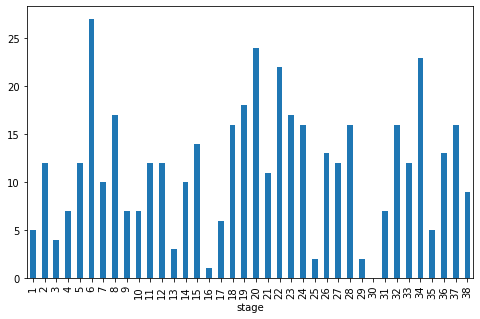

In [32]:
df_match_spain_sub.groupby('stage')['home_result'].sum().plot.bar(figsize=(8,5))

<AxesSubplot:>

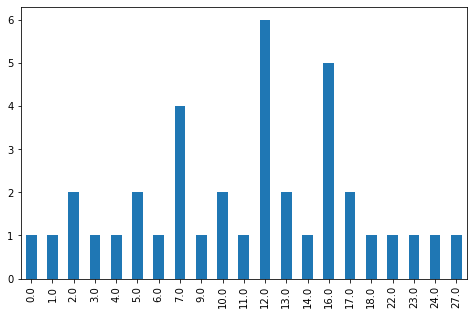

In [33]:
df_match_spain_sub.groupby('stage')['home_result'].sum().value_counts().sort_index().plot.bar(figsize=(8,5))

In [34]:
df_match_spain_sub.head()

,id,country_id,league_id,season,stage,date,home_team_goal,away_team_goal,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA,year,home_result,target
22277,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,4,0,875448,9906,9869,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,1.53,4.0,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,1.50,3.80,6.00,1.53,3.80,6.0,2010,1.0,win
22279,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,3,875458,8696,8634,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,15.00,6.0,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,11.00,5.50,1.22,15.00,6.50,1.2,2010,-1.0,loss
22280,22281,21518,21518,2010/2011,1,2010-08-28 00:00:00,1,3,875459,9864,10267,33826.0,33843.0,188517.0,41707.0,163236.0,11758.0,24612.0,128870.0,23779.0,56819.0,51545.0,24494.0,34007.0,30276.0,30914.0,26403.0,108568.0,30666.0,37824.0,41468.0,32762.0,33028.0,2.88,3.3,2.4,2.85,3.30,2.35,2.7,3.2,2.40,2.8,3.2,2.20,2.90,3.25,2.25,2.88,3.20,2.4,2010,-1.0,loss
22281,22282,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,0,875462,9783,8394,96651.0,33756.0,37451.0,70891.0,18853.0,37449.0,37793.0,114680.0,45744.0,31045.0,166111.0,30664.0,37754.0,33582.0,27668.0,150968.0,33635.0,30534.0,38403.0,164676.0,45457.0,8780.0,2.10,3.3,3.5,2.05,3.25,3.50,2.0,3.2,3.40,2.0,3.2,3.20,1.91,3.30,3.75,2.05,3.25,3.5,2010,0.0,draw
22283,22284,21518,21518,2010/2011,1,2010-08-29 00:00:00,3,1,875464,8558,8305,113695.0,45440.0,183331.0,182921.0,33767.0,80492.0,121716.0,24852.0,37441.0,150330.0,40165.0,30992.0,41470.0,32675.0,75397.0,37622.0,34381.0,38431.0,75619.0,75307.0,37461.0,150770.0,2.10,3.3,3.5,2.15,3.25,3.25,2.0,3.2,3.40,2.1,3.2,3.00,2.10,3.25,3.25,2.10,3.20,3.5,2010,1.0,win


In [35]:
df_player_spain_attr.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id_attributes,player_api_id_attributes,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,year
4469,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27907,722766,2016-06-23 00:00:00,71.0,86.0,right,high,medium,59.0,67.0,59.0,70.0,52.0,80.0,54.0,52.0,71.0,73.0,83.0,80.0,81.0,65.0,85.0,49.0,50.0,69.0,46.0,62.0,32.0,21.0,61.0,67.0,54.0,21.0,20.0,22.0,6.0,6.0,7.0,8.0,9.0,2016
4479,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27917,722766,2015-10-23 00:00:00,61.0,77.0,right,medium,medium,55.0,53.0,14.0,60.0,52.0,71.0,54.0,52.0,55.0,62.0,81.0,75.0,79.0,59.0,85.0,46.0,27.0,46.0,21.0,58.0,18.0,16.0,47.0,59.0,55.0,16.0,18.0,22.0,6.0,6.0,7.0,8.0,9.0,2015
4483,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27921,722766,2014-11-14 00:00:00,58.0,75.0,right,medium,low,54.0,52.0,25.0,59.0,51.0,64.0,53.0,51.0,54.0,61.0,71.0,61.0,79.0,58.0,85.0,45.0,27.0,46.0,21.0,57.0,25.0,25.0,46.0,58.0,54.0,25.0,25.0,21.0,5.0,5.0,6.0,7.0,8.0,2014
4486,1680,722766,Charly Musonda,204233,1996-10-15 00:00:00,172.72,146,27924,722766,2007-02-22 00:00:00,58.0,75.0,right,medium,low,54.0,52.0,25.0,59.0,51.0,64.0,53.0,51.0,54.0,61.0,71.0,61.0,79.0,58.0,85.0,45.0,27.0,46.0,21.0,57.0,25.0,25.0,46.0,58.0,54.0,25.0,25.0,21.0,5.0,5.0,6.0,7.0,8.0,2007
13304,5159,710807,Jonatan Montiel,231873,1998-09-03 00:00:00,172.72,148,85527,710807,2016-04-21 00:00:00,67.0,77.0,left,medium,low,39.0,66.0,45.0,69.0,30.0,70.0,31.0,38.0,67.0,68.0,69.0,62.0,60.0,64.0,79.0,40.0,62.0,55.0,42.0,65.0,59.0,38.0,66.0,65.0,37.0,28.0,37.0,39.0,10.0,12.0,10.0,9.0,6.0,2016


In [36]:
df_player_spain_attr['age'] = (pd.to_datetime(df_player_spain_attr['date']) - pd.to_datetime(df_player_spain_attr['birthday'])).dt.days // 365.25
df_player_spain_attr['age'].describe()

count    9789.000000
mean       24.951374
std         4.833167
min         8.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        41.000000
Name: age, dtype: float64

# Merge player features

In [37]:
print(df_match_spain_sub.shape)
print(df_player_spain_attr.shape)

(2173, 54)
(9789, 50)


In [38]:
for col in tqdm(df_match_spain_sub.columns):
    if 'player' in col:
        num = col.split('_')[-1]
        home_or_away = col.split('_')[0]
        df_player_sub = df_player_spain_attr[
            ['player_api_id', 'overall_rating', 'potential', 'year']].rename(columns={
            'overall_rating': '{}_overall_rating_{}'.format(home_or_away, num),
            'potential': '{}_potential_{}'.format(home_or_away, num)
        })
        df_match_spain_sub = pd.merge(
            df_match_spain_sub,
            df_player_sub,
            left_on=[col, 'year'],
            right_on=['player_api_id', 'year'],
            how='left',
        )
        df_match_spain_sub = df_match_spain_sub.drop(columns=['player_api_id'])

100%|██████████| 54/54 [00:00<00:00, 244.09it/s]


In [39]:
print(df_match_spain_sub.shape)
df_match_spain_sub.head()

(2173, 98)


,id,country_id,league_id,season,stage,date,home_team_goal,away_team_goal,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA,year,home_result,target,home_overall_rating_1,home_potential_1,home_overall_rating_2,home_potential_2,home_overall_rating_3,home_potential_3,home_overall_rating_4,home_potential_4,home_overall_rating_5,home_potential_5,home_overall_rating_6,home_potential_6,home_overall_rating_7,home_potential_7,home_overall_rating_8,home_potential_8,home_overall_rating_9,home_potential_9,home_overall_rating_10,home_potential_10,home_overall_rating_11,home_potential_11,away_overall_rating_1,away_potential_1,away_overall_rating_2,away_potential_2,away_overall_rating_3,away_potential_3,away_overall_rating_4,away_potential_4,away_overall_rating_5,away_potential_5,away_overall_rating_6,away_potential_6,away_overall_rating_7,away_potential_7,away_overall_rating_8,away_potential_8,away_overall_rating_9,away_potential_9,away_overall_rating_10,away_potential_10,away_overall_rating_11,away_potential_11
0,22278,21518,21518,2010/2011,1,2010-08-30 00:00:00,4,0,875448,9906,9869,182917.0,30689.0,56678.0,32656.0,33636.0,38821.0,37411.0,25924.0,33871.0,38460.0,37412.0,75195.0,150480.0,107929.0,101070.0,74752.0,38746.0,30273.0,38004.0,38886.0,24383.0,41294.0,1.53,4.0,6.0,1.53,3.80,6.00,1.5,3.8,5.70,1.5,3.5,6.00,1.50,3.80,6.00,1.53,3.80,6.0,2010,1.0,win,78.0,85.0,79.0,84.0,81.0,82.0,76.0,81.0,77.0,84.0,82.0,85.0,80.0,83.0,78.0,80.0,75.0,81.0,87.0,88.0,84.0,90.0,77.0,78.0,72.0,73.0,77.0,78.0,78.0,79.0,74.0,79.0,74.0,79.0,75.0,76.0,74.0,77.0,76.0,77.0,78.0,79.0,74.0,79.0
1,22280,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,3,875458,8696,8634,37579.0,75606.0,128037.0,37879.0,74435.0,26535.0,37512.0,46836.0,97319.0,38382.0,35638.0,32657.0,33988.0,37482.0,30738.0,34304.0,39854.0,154257.0,26146.0,30981.0,30909.0,30955.0,15.00,6.0,1.2,12.50,6.00,1.20,9.0,5.0,1.27,10.0,5.0,1.22,11.00,5.50,1.22,15.00,6.50,1.2,2010,-1.0,loss,74.0,80.0,74.0,75.0,77.0,82.0,73.0,80.0,74.0,75.0,70.0,76.0,75.0,80.0,70.0,74.0,73.0,76.0,75.0,79.0,77.0,86.0,85.0,86.0,84.0,90.0,85.0,88.0,82.0,85.0,79.0,84.0,87.0,90.0,81.0,84.0,81.0,85.0,90.0,95.0,88.0,92.0,87.0,90.0
2,22281,21518,21518,2010/2011,1,2010-08-28 00:00:00,1,3,875459,9864,10267,33826.0,33843.0,188517.0,41707.0,163236.0,11758.0,24612.0,128870.0,23779.0,56819.0,51545.0,24494.0,34007.0,30276.0,30914.0,26403.0,108568.0,30666.0,37824.0,41468.0,32762.0,33028.0,2.88,3.3,2.4,2.85,3.30,2.35,2.7,3.2,2.40,2.8,3.2,2.20,2.90,3.25,2.25,2.88,3.20,2.4,2010,-1.0,loss,67.0,72.0,78.0,82.0,72.0,73.0,76.0,77.0,67.0,75.0,74.0,77.0,73.0,77.0,74.0,76.0,72.0,85.0,73.0,81.0,69.0,74.0,79.0,80.0,77.0,81.0,79.0,81.0,77.0,81.0,77.0,85.0,81.0,86.0,78.0,81.0,80.0,87.0,82.0,88.0,79.0,74.0,79.0,81.0
3,22282,21518,21518,2010/2011,1,2010-08-29 00:00:00,0,0,875462,9783,8394,96651.0,33756.0,37451.0,70891.0,18853.0,37449.0,37793.0,114680.0,45744.0,31045.0,166111.0,30664.0,37754.0,33582.0,27668.0,150968.0,33635.0,30534.0,38403.0,164676.0,45457.0,8780.0,2.10,3.3,3.5,2.05,3.25,3.50,2.0,3.2,3.40,2.0,3.2,3.20,1.91,3.30,3.75,2.05,3.25,3.5,2010,0.0,draw,69.0,78.0,76.0,85.0,80.0,84.0,77.0,81.0,71.0,75.0,76.0,83.0,73.0,70.0,73.0,81.0,74.0,82.0,81.0,89.0,72.0,81.0,78.0,83.0,71.0,67.0,74.0,88.0,76.0,77.0,72.0,79.0,73.0,82.0,75.0,81.0,72.0,67.0,75.0,83.0,73.0,81.0,73.0,72.0
4,22284,21518,21518,2010/2011,1,2010-08-29 00:00:00,3,1,875464,8558,8305,113695.0,45440.0,183331.0,182921.0,33767.0,80492.0,121716.0,24852.0,37441.0,150330.0,40165.0,30992.0,41470.0,32675.0,75397.0,37622.0,34381.0,38431.0,75619.0,75307.0,37461.0,150770.0,2.10,3.3,3.5,2.15,3.25,3.25,2.0,3.2,3.40,2.1,3.2,3.00,2.10,3.

In [40]:
df_match_spain_merged = df_match_spain_sub.dropna()
print(df_match_spain_merged.shape)

(1898, 98)
